# Simple Seq2Seq machine translation using GRU based encoder-decoder architecture 

In [1]:
import torch
from torch import nn
import numpy as np
import time

## Preparing the dataset for Machine Translation

In [2]:
from ProcessData import *

Go.	Va !
Hi.	Salut !
go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
['stop', '!'] ['stop', '!']
['i', 'try', '.'] ["j'essaye", '.']
Batch of 2 sentences:
X: tensor([[  6, 124,   4,   3,   1,   1,   1,   1],
        [  6,  18, 101,   4,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([4, 5])
Y: tensor([[  6,  27,   7,   0,   4,   3,   1,   1],
        [  6,   7, 158,   4,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([6, 5])
{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '.': 4, '!': 5, 'i': 6, "i'm": 7, 'it': 8, 'go': 9, 'tom': 10, '?': 11, 'me': 12, 'get': 13, 'be': 14, 'up': 15, 'come': 16, 'we': 17, 'am': 18, 'this': 19, 'lost': 20, 'on': 21, 'won': 22, 'us': 23, "it's": 24, 'down': 25, 'no': 26, 'nice': 27, 'away': 28, 'you': 29, 'back': 30, 'try': 31, 'way': 32, 'fair': 33, 'out': 34, 'lazy': 35, 'help': 36, 'hold': 37, 'off': 38, 'grab': 39, 'how': 40, 'who': 41, 'got': 42, 'calm': 43, 'call': 44, 'he

## Encoder

In [3]:
class Seq2SeqEncoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        
        super(Seq2SeqEncoder, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout, batch_first=True)

    def forward(self, X):
        # Input X: (`batch_size`, `num_steps`, `input_size`)
        
        X = self.embedding(X)
        # After embedding X: (`batch_size`, `num_steps`, `embed_size`)
        
        # When batch_first is True:
        # in RNN models, the first axis corresponds to batch_size 
        #                the second axis corresponds to num_steps
        #                the first axis corresponds to embed_dim
        
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`batch_size`, `num_steps`, `num_hiddens`)
        # `state` shape:  (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=1)
encoder.eval()
X = torch.zeros((5, 4), dtype=torch.long)
enc_output, enc_state = encoder(X)

print(enc_output.shape)
print(enc_state.shape)

torch.Size([5, 4, 16])
torch.Size([1, 5, 16])


## Decoder

In [5]:
class Seq2SeqDecoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout,batch_first=True)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def forward(self, X, state):
        # Inputs: 
        # X : (`batch_size`, `num_steps`, `input_size`)
        # initial hidden state : (`num_layers`, `batch_size`, `num_hiddens`) , 
        # This comes from hidden state output from encoder.
                
        X = self.embedding(X)
        # After embedding X: (`batch_size`, `num_steps`, `embed_size`)
        
        # Context is last layer hidden state from last timestep of encoder 
        
        # last layer hidden state from last time step of encoder
        last_layer_state = state[-1] # shape (`batch_size`,`num_hiddens`)
        
        # context is last timestep hidden state of encoder.
        # Broadcast `context` so it has the same `num_steps` as `X` 
        context = last_layer_state.repeat(X.shape[1], 1, 1).permute(1,0,2)
        
        # context has now shape (`batch_size`,`num_steps`,`num_hiddens`) 
        
        # concat(X,context) = X_and_context of shape (`batch_size`,`num_steps`,`emb_dim + num_hiddens`)
        X_and_context = torch.cat((X, context), 2)
        
        output, state = self.rnn(X_and_context, state)
        # output : (`batch_size`,`num_steps`,`num_hiddens`)
        # state : (`num_layers`,`batch_size`,`num_hiddens`), this is final timestep hidden state of decoder
        
        output = self.dense(output)
        
        # final output of decoder :
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)

        return output, state

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=1)
decoder.eval()

output, state = decoder(X, enc_state)
output.shape, state.shape

(torch.Size([5, 4, 10]), torch.Size([1, 5, 16]))

In [7]:
# You can feed input consisting of a single timestep as well.
dec_X = torch.from_numpy(np.zeros((5,1))).long()
print(dec_X.shape) # batch_size=5, num_steps=1

output, state = decoder(dec_X, enc_state)
output.shape, state.shape

torch.Size([5, 1])


(torch.Size([5, 1, 10]), torch.Size([1, 5, 16]))

## Putting encoder and decoder together

In [8]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_output, enc_state = self.encoder(enc_X)
        return self.decoder(dec_X, enc_state)    
    
encoder_decoder = EncoderDecoder(encoder,decoder)
encoder_decoder.eval()

EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(10, 8)
    (rnn): GRU(8, 16, batch_first=True)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(10, 8)
    (rnn): GRU(24, 16, batch_first=True)
    (dense): Linear(in_features=16, out_features=10, bias=True)
  )
)

## Allow parts of sequence to be masked as we have variable length sequences

In [9]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen),device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
valid_lens = torch.tensor([1, 2])
print('Input has 2 sequences :\n',X)
print('Assume that first sequence has 1 valid elements, second sequence has 2 valid elements', valid_lens)

print('After masking:\n',sequence_mask(X, valid_lens))

Input has 2 sequences :
 tensor([[1, 2, 3],
        [4, 5, 6]])
Assume that first sequence has 1 valid elements, second sequence has 2 valid elements tensor([1, 2])
After masking:
 tensor([[1, 0, 0],
        [4, 5, 0]])


## Build cross entropy loss using masked sequences

In [10]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    
    def forward(self, pred, label, valid_len):
        
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len).float()
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

loss = MaskedSoftmaxCELoss()

## Prepare for training

In [11]:
embed_size = 32
num_hiddens = 32
num_layers = 2

dropout = 0.1
batch_size = 64
num_steps = 10
lr = 0.005
num_epochs = 300 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device=',device)

data_path = '../data/fra-eng/fra.txt'
train_iter, src_vocab, tgt_vocab = load_data_nmt(data_path, batch_size, num_steps)

encoder = Seq2SeqEncoder( len(src_vocab), embed_size, num_hiddens, num_layers, dropout )
decoder = Seq2SeqDecoder( len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout )

net = EncoderDecoder(encoder, decoder)

net.eval()


device= cuda:0


EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(184, 32)
    (rnn): GRU(32, 32, num_layers=2, batch_first=True, dropout=0.1)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(201, 32)
    (rnn): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.1)
    (dense): Linear(in_features=32, out_features=201, bias=True)
  )
)

## Initialize weights in GRU layers of encoder and decoder

In [12]:
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
        #initialize biases and weights
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.constant(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_uniform_(m._parameters[name])

net.apply(xavier_init_weights)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = MaskedSoftmaxCELoss()
net.train()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(184, 32)
    (rnn): GRU(32, 32, num_layers=2, batch_first=True, dropout=0.1)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(201, 32)
    (rnn): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.1)
    (dense): Linear(in_features=32, out_features=201, bias=True)
  )
)

## Training

In [14]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    
    
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

            
cum_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    
    for batch in train_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
        Y_hat, _ = net(X, dec_input)
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()  # Make the loss scalar for `backward`
        grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        optimizer.step()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    if (epoch + 1) % 10 == 0:
        print(epoch+1,metric[0] / metric[1])
        cum_losses.append(metric[0] / metric[1])
    elapsed_time = time.time() - start_time
    
    
print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / elapsed_time:.1f} 'f'tokens/sec on {str(device)}')

10 0.2090059375725408
20 0.1508961954908735
30 0.1133520789898929
40 0.08690908657946206
50 0.07063316426282791
60 0.060021722659216487
70 0.05148320665325719
80 0.044760870867852666
90 0.039765634578027766
100 0.0361578657795059
110 0.0323923955232034
120 0.030629563359752598
130 0.02831386459572772
140 0.027698246806871697
150 0.02605452747712779
160 0.025122531799292386
170 0.02461659434460036
180 0.023439871518924356
190 0.022659589061114038
200 0.022360768012294897
210 0.021564902962778836
220 0.021263796998871824
230 0.021205942258268114
240 0.02060909357562585
250 0.020626334025605556
260 0.020763019181198605
270 0.020957735334499197
280 0.020493817395086787
290 0.020140862192801725
300 0.02038786731241069
loss 0.020, 29684.8 tokens/sec on cuda:0


## Plot the loss over epochs

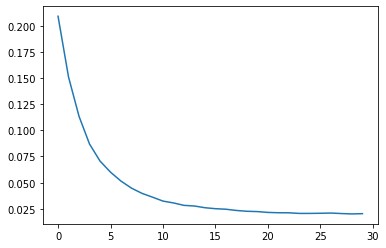

In [16]:
import matplotlib.pyplot as plt

X = range(len(cum_losses))
plt.plot(X, cum_losses)
plt.show()

## Prediction

In [44]:
def translate_a_sentence(src_sentence, src_vocab, bos_token, num_steps):

    # First process the src_sentence, tokenize and truncate/pad it.
    #src_sentence : a sentence to translate

    #Tokenize the sentence
    src_sentence_words = src_sentence.lower().split(' ')
    print('src sentence words = ',src_sentence_words)

    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_tokens = src_tokens + [src_vocab['<eos>']]
    print('src_tokens = ',src_tokens)

    enc_valid_len = torch.tensor([len(src_tokens)], device=device)

    #Truncate the sentence to num_steps if the sentence is longer. If shorter, pad the sentence.
    print('Truncating/padding to length',num_steps)
    padding_token = src_vocab['<pad>']
    if len(src_tokens) > num_steps:
        line[:num_steps]  # Truncate
    #Pad 
    src_tokens = src_tokens + [padding_token] * (num_steps - len(src_tokens))
    print('After truncating/padding',src_tokens,'\n')
    
    # Next convert the src_tokens to a tensor to be fed to the decoder one word at a timestep
    # Covert src_tokens to a tesnor, add the batch axis
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # Now shape of enc_X : (`batch_size` , `num_steps`) = (1,10)
    # Pass it through the encoder
    enc_output, enc_state = net.encoder(enc_X)

    # feed the decoder one word token at a time
    # prepare the first token for decoder : beginning of sentence
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    #Initialize input state for the decoder to be the final timestep state of the encoder
    dec_input_state = enc_state
    output_token_seq = []
    for _ in range(num_steps):
        curr_output, curr_dec_state = decoder(dec_X, dec_input_state)
        dec_input_state = curr_dec_state
        
        # curr_output is of shape (`batch_size`, `num_steps`, `len(tgt_vocab)`) = (1,10,201)
        # Use the token with the highest prediction likelihood as the input of the decoder for the next time step
        dec_X = curr_output.argmax(dim=2) #next timestep input for decoder
        
        #remove batch_size dimension as we are working with single sentences
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        #eos predicted, stop
        if pred == tgt_vocab['<eos>']:
            break
        output_token_seq.append(pred)
    
    return output_token_seq

### Lets look for some translation

In [46]:
english_batch = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
french_batch = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

bos_token = tgt_vocab['<bos>']
for eng_sent, fr_sent in zip(english_batch,french_batch):
    
    fr_sent_predicted_tokens = translate_a_sentence(eng_sent, src_vocab, bos_token, num_steps)
    fr_sent_predicted = ' '.join(tgt_vocab.to_tokens(fr_sent_predicted_tokens))
    print(f'Actual    translation: english:{eng_sent} => french:{fr_sent}')
    print(f'Predicted translation: english:{eng_sent} => french:{fr_sent_predicted}')
    print('-------------------------------------------------------------------')

src sentence words =  ['go', '.']
src_tokens =  [9, 4, 3]
Truncating/padding to length 10
After truncating/padding [9, 4, 3, 1, 1, 1, 1, 1, 1, 1] 

Actual    translation: english:go . => french:va !
Predicted translation: english:go . => french:va au gagné ?
-------------------------------------------------------------------
src sentence words =  ['i', 'lost', '.']
src_tokens =  [6, 20, 4, 3]
Truncating/padding to length 10
After truncating/padding [6, 20, 4, 3, 1, 1, 1, 1, 1, 1] 

Actual    translation: english:i lost . => french:j'ai perdu .
Predicted translation: english:i lost . => french:j'ai perdu .
-------------------------------------------------------------------
src sentence words =  ["he's", 'calm', '.']
src_tokens =  [58, 43, 4, 3]
Truncating/padding to length 10
After truncating/padding [58, 43, 4, 3, 1, 1, 1, 1, 1, 1] 

Actual    translation: english:he's calm . => french:il est calme .
Predicted translation: english:he's calm . => french:il est mouillé !
----------------